In [0]:
import os
# To work with Amazon S3 storage, set the following variables using your AWS Access Key and Secret Key
# Set the Region to where your files are stored in S3.
access_key = 'xxxxxxxxxxxxxx'
secret_key = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxx'
# Set the environment variables so boto3 can pick them up later
os.environ['AWS_ACCESS_KEY_ID'] = access_key
os.environ['AWS_SECRET_ACCESS_KEY'] = secret_key
encoded_secret_key = secret_key.replace("/", "%2F")
aws_region = "us-east-2"

# Update the Spark options to work with our AWS Credentials
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", access_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", secret_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3." + aws_region + ".amazonaws.com")

clean_sdf = spark.read.parquet('s3a://hvfhv-project-mc/raw/cleaned_fhvhv_tripdata_2023-01.parquet')

In [0]:
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Binarizer, Bucketizer, MinMaxScaler
from pyspark.ml.stat import Correlation, ChiSquareTest, Summarizer
from pyspark.ml import Pipeline

# Import the logistic regression model
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel

# Import the evaluation module
from pyspark.ml.evaluation import *

# Import the model tuning module
from pyspark.ml.tuning import *

# Import other modeling modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the Spark logging level to only show errors
sc.setLogLevel("ERROR")

In [0]:
# FEATURE ENGINEERING SECTION

# Rename trip_time to trip_time_secs
# Convert trip_time_secs from long to double

trip_time_sec = clean_sdf.withColumnRenamed('trip_time', 'trip_time_secs')
trip_time_sec_sdf = trip_time_sec.withColumn('trip_time_secs', col('trip_time_secs').cast('double'))

# Subtract request_datetime from pickup_datetime to get total wait time from after request was submitted, in seconds. Convert to double.

total_wait_secs_sdf = trip_time_sec_sdf.withColumn('total_wait_secs', col('pickup_datetime').cast('double') - col('request_datetime').cast('double'))

# Extract the hour from pickup_datetime to know what time of day the ride occurred. Convert to double.

pickup_hour_sdf = total_wait_secs_sdf.withColumn('pickup_hour', hour(col('pickup_datetime')).cast('double'))

# Bucketize pickup_hour by 6 hour periods: <=6 = Early Morning, <12 = Morning, ==12 = Noon, <=18 = Afternoon, <=24 = Night

bucketized_pickup_hour_sdf = pickup_hour_sdf.withColumn('pickup_time_of_day', when(col('pickup_hour') <= 6, 'Early Morning').when(col('pickup_hour') < 12, "Morning").when(col('pickup_hour') == 12, 'Noon').when(col('pickup_hour') <= 18, "Afternoon").when(col('pickup_hour') <= 24, "Night"))

# Extract the day of the week from pickup_datetime to know what day the ride occurred. Convert to double.

day_of_week_num_sdf = bucketized_pickup_hour_sdf.withColumn('day_of_week_num', dayofweek(col('pickup_datetime')).cast('double'))

# Create a column called day_name to specify the day name associated with day_of_week_num

bucketized_day_name_sdf = day_of_week_num_sdf.withColumn('day_name', when(col('day_of_week_num') == 1, 'Monday').when(col('day_of_week_num') == 2, 'Tuesday').when(col('day_of_week_num') == 3, 'Wednesday').when(col('day_of_week_num') == 4, 'Thursday').when(col('day_of_week_num') == 5, 'Friday').when(col('day_of_week_num') == 6, 'Saturday').when(col('day_of_week_num') == 7, 'Sunday'))

# Binarize day_of_week to 0 or 1, where 0.0 = Weekday, 1.0 = Weekend

binarizer_day = Binarizer(threshold=5.0, inputCol='day_of_week_num', outputCol='weekday_or_weekend')
weekday_or_weekend_sdf = binarizer_day.transform(bucketized_day_name_sdf)

# Create a column called total_fare that includes all of the ride costs

total_fare_sdf = weekday_or_weekend_sdf.withColumn('total_fare', col('base_passenger_fare') + col('tolls') + col('bcf') + col('sales_tax') + col('congestion_surcharge') + col('airport_fee'))

# Drop all rows where total_fare is equal to 0.0 to avoid a divide by zero error
# Create a column called tip_percent that is tips divided by total_fare to get the tip percent

non_zero_fare = total_fare_sdf.where(col('total_fare') > 0.0)
tip_percent_sdf = non_zero_fare.withColumn('tip_percent', col('tips') / col('total_fare'))

tip_percent_sdf.show()

+-------------------+-------------------+-------------------+-------------------+----------+--------------+-------------------+-----+----+---------+--------------------+-----------+-----+---------------+-----------+------------------+---------------+--------+------------------+------------------+-------------------+
|   request_datetime|  on_scene_datetime|    pickup_datetime|   dropoff_datetime|trip_miles|trip_time_secs|base_passenger_fare|tolls| bcf|sales_tax|congestion_surcharge|airport_fee| tips|total_wait_secs|pickup_hour|pickup_time_of_day|day_of_week_num|day_name|weekday_or_weekend|        total_fare|        tip_percent|
+-------------------+-------------------+-------------------+-------------------+----------+--------------+-------------------+-----+----+---------+--------------------+-----------+-----+---------------+-----------+------------------+---------------+--------+------------------+------------------+-------------------+
|2023-01-01 00:18:06|2023-01-01 00:19:24|2023-

In [0]:
# trip_time_secs (double)
# PIPELINE CREATION SECTION

# Create a label. =1 if >= 0.01, =0 otherwise
binarizer_tip = Binarizer(threshold=0.01, inputCol='tip_percent', outputCol='label')
tip_label = binarizer_tip.transform(tip_percent_sdf)

# Create an indexer for the string based columns
indexer = StringIndexer(inputCols=["pickup_time_of_day", "day_name"], outputCols=["pickup_time_of_day_index", "day_name_index"])

# Create an encoder for the three indexes and the age integer column
encoder = OneHotEncoder(inputCols=['pickup_time_of_day_index', 'day_name_index'], outputCols=['pickup_time_of_day_vector', 'day_name_vector'], dropLast=False)

# Create an assembler for the individual feature vectors and the float/double columns
assembler = VectorAssembler(inputCols=['trip_miles', 'trip_time_secs', 'total_wait_secs', 'pickup_time_of_day_vector', 'day_name_vector', 'weekday_or_weekend', 'total_fare'], outputCol='features')

# Scale the features columns so the min = 0.0 and max = 1.0
min_max_scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

# Create the pipeline
hvfhv_pipe = Pipeline(stages=[indexer, encoder, assembler, min_max_scaler])

# Call .fit to transform the data
transformed_sdf = hvfhv_pipe.fit(tip_label).transform(tip_label)

# Review the transformed features
transformed_sdf.select('trip_miles', 'trip_time_secs', 'total_wait_secs', 'pickup_time_of_day', 'day_name', 'weekday_or_weekend', 'total_fare', 'tip_percent', 'label', 'features', 'scaled_features').show(truncate=False)

In [0]:
# MODEL EVALUATION SECTION

# Save the confusion matrix
cm = test_results.groupby('label').pivot('prediction').count().fillna(0).collect()

def calculate_recall_precision(cm):
    tn = cm[0][1] # True Negative
    fp = cm[0][2] # False Positive
    fn = cm[1][1] # False Negative
    tp = cm[1][2] # True Positive
    precision = tp / ( tp + fp )
    recall = tp / ( tp + fn )
    accuracy = ( tp + tn ) / ( tp + tn + fp + fn )
    f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )
    return accuracy, precision, recall, f1_score

print('Accuracy, Precision, Recall, F1 Score')
print(calculate_recall_precision(cm))

Accuracy, Precision, Recall, F1 Score
(0.8035169530544966, 0.3547841385843822, 0.006587999361681542, 0.012935793510884891)


In [0]:
# MODEL EVALUATION SECTION
# RUN CROSS-VALIDATOR ON TRAINING DATA

# Create a BinaryClassificationEvaluator to evaluate how well the model works
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")

# Create the parameter grid (empty for now)
grid = ParamGridBuilder().build()

# Create the CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator, numFolds=3 )

# Use the CrossValidator to Fit the training data
cv = cv.fit(trainingData)

# Show the average performance over the three folds
print('cv.avgMetrics:', cv.avgMetrics)

cv.avgMetrics: [0.597391640511259]


In [0]:
# MODEL EVALUATION SECTION

# Evaluate the test data using the cross-validator model
# Reminder: We used Area Under the Curve
print('evaluator.evaluate(cv.transform(testData)):', evaluator.evaluate(cv.transform(testData)))

evaluator.evaluate(cv.transform(testData)): 0.5967987430092285


In [0]:
# MODEL EVALUATION SECTION 
# PARAMETER GRID SEARCH

# Create a grid to hold hyperparameters
grid = ParamGridBuilder()
grid = grid.addGrid(lr.regParam, [0.0, 1.0] )
grid = grid.addGrid(lr.elasticNetParam, [0, 1])

# Build the grid
grid = grid.build()
print('Number of models to be tested:', len(grid))

# Create the CrossValidator using the new hyperparameter grid
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator)

# Call cv.fit() to create models with all of the combinations of parameters in the grid
all_models = cv.fit(trainingData)
print("Average Metrics for Each model:", all_models.avgMetrics)

  File <command-3046472966897617>:3
    hvfhv_pipeline = Pipeline(stages=[indexer, encoder, assembler, min_max_scaler lr])
                              ^
SyntaxError: expression cannot contain assignment, perhaps you meant "=="?


In [0]:
# MODEL EVALUATION SECTION
# CHARACTERISTICS OF BEST MODEL

# Gather the metrics and parameters of the model with the best average metrics
hyperparams = all_models.getEstimatorParamMaps()[np.argmax(all_models.avgMetrics)]

# Print out the list of hyperparameters for the best model
for i in range(len(hyperparams.items())):
    print([x for x in hyperparams.items()][i])

#(Param(parent='LogisticRegression_2effdf339a6c', name='regParam', doc='regularization parameter (>= 0).'), 0.4)
#(Param(parent='LogisticRegression_2effdf339a6c', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'), 0.0)

# Choose the best model
bestModel = all_models.bestModel
print("Area under ROC curve:", bestModel.summary.areaUnderROC)

# Area under ROC curve: 1.0

(Param(parent='LogisticRegression_17a1dd38758b', name='regParam', doc='regularization parameter (>= 0).'), 0.0)
(Param(parent='LogisticRegression_17a1dd38758b', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'), 1.0)
Area under ROC curve: 0.5974020384171882


In [0]:
# MODEL EVALUATION SECTION
# TEST BEST MODEL ON TEST DATA

# Use the model 'bestModel' to predict the test set
test_results = bestModel.transform(testData)

# Show the results
test_results.select('trip_miles', 'trip_time_secs', 'total_wait_secs', 'pickup_time_of_day', 'day_name', 'weekday_or_weekend', 'total_fare', 'tip_percent','probability','prediction', 'label').show(truncate=False)

# Evaluate the predictions. Area Under ROC curve
print('evaluator.evaluate(test_results):', evaluator.evaluate(test_results))

evaluator.evaluate(test_results): 0.5967990841302269


In [0]:
# Save best model to models folder in S3
bestModel.write().overwrite().save('s3://hvfhv-project-mc/models/hvfhv_logistic_regression_model')

# Save transformed_sdf dataframe as parquet file in trusted folder
transformed_sdf.write.parquet('s3://hvfhv-project-mc/trusted/feature_engineered_fhvhv_tripdata_2023-01.parquet')

In [0]:
transformed_sdf.show()

+-------------------+-------------------+-------------------+-------------------+----------+--------------+-------------------+-----+----+---------+--------------------+-----------+-----+---------------+-----------+------------------+---------------+--------+------------------+------------------+-------------------+-----+------------------------+--------------+-------------------------+---------------+--------------------+--------------------+
|   request_datetime|  on_scene_datetime|    pickup_datetime|   dropoff_datetime|trip_miles|trip_time_secs|base_passenger_fare|tolls| bcf|sales_tax|congestion_surcharge|airport_fee| tips|total_wait_secs|pickup_hour|pickup_time_of_day|day_of_week_num|day_name|weekday_or_weekend|        total_fare|        tip_percent|label|pickup_time_of_day_index|day_name_index|pickup_time_of_day_vector|day_name_vector|            features|     scaled_features|
+-------------------+-------------------+-------------------+-------------------+----------+------------

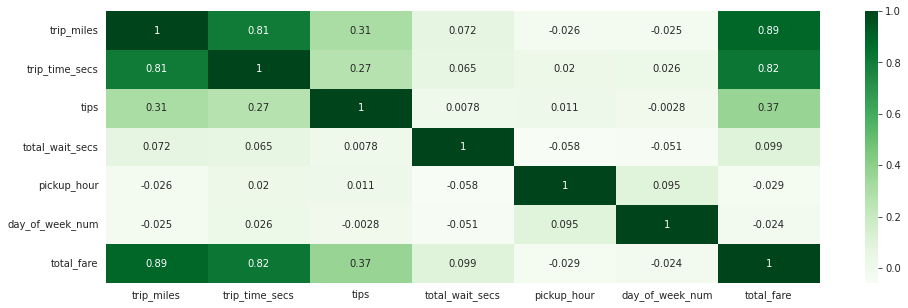

In [0]:
# CORRELATION MATRIX
# Correlation matrix using Seaborn
# Convert the numeric values to vector columns
vector_column = "correlation_features"
# Choose the numeric (Double) columns 
numeric_columns = ['trip_miles', 'trip_time_secs', 'tips', 'total_wait_secs', 'pickup_hour', 'day_of_week_num', 'total_fare']
assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_column)
sdf_vector = assembler.transform(transformed_sdf).select(vector_column)

# Create the correlation matrix, then get just the values and convert to a list
matrix = Correlation.corr(sdf_vector, vector_column).collect()[0][0]
correlation_matrix = matrix.toArray().tolist() 
# Convert the correlation to a Pandas dataframe
correlation_matrix_df = pd.DataFrame(data=correlation_matrix, columns=numeric_columns, index=numeric_columns) 

plt.figure(figsize=(16,5))  
# Set the style for Seaborn plots
sns.set_style("white")

sns.heatmap(correlation_matrix_df, 
            xticklabels=correlation_matrix_df.columns.values,
            yticklabels=correlation_matrix_df.columns.values,  cmap="Greens", annot=True)
plt.savefig("correlation_matrix.png")

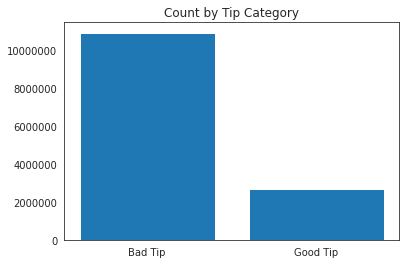

In [0]:
# VISUALIZATION 1 (BAR - TIP CATEGORY)

tips_category = transformed_sdf.withColumn('tip_type', when(transformed_sdf.label == 1.0, 'Good Tip').when(transformed_sdf.label == 0.0, 'Bad Tip'))

# Show frequency of the tip 'label' column
tip_category_df = tips_category.groupby('tip_type').count().sort('tip_type').toPandas()
# Set up a figure
fig = plt.figure(facecolor='white')
plt.ticklabel_format(style='plain')
# Bar Plot of tip 'label' and count
plt.bar(tip_category_df['tip_type'],tip_category_df['count'] )
# fig.tight_layout()
plt.title("Count by Tip Category")
plt.savefig("frequency_tip_category.png")

Out[69]: <seaborn.axisgrid.FacetGrid at 0x7f2772948a30>

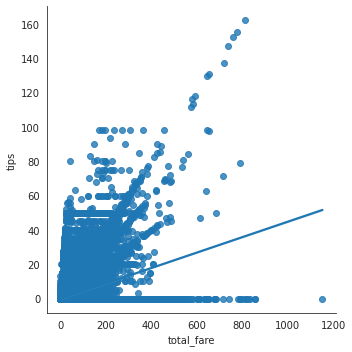

In [0]:
# VISUALIZATION 2 (RELATIONSHIP - TOTAL FARE, TIPS)
# Relationship plot using Seaborn
import seaborn as sns
# Take the order total column and convert to a Pandas dataframe
total_fare_tips_df = transformed_sdf.select('total_fare', 'tips').sample(False, 0.25).toPandas() 

# Set the style for Seaborn plots
sns.set_style("white")

# Create the relationship plot
sns.lmplot(x='total_fare', y='tips', data=total_fare_tips_df)

Out[79]: <seaborn.axisgrid.FacetGrid at 0x7f2771aac190>

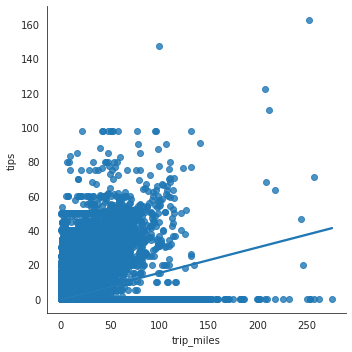

In [0]:
# VISUALIZATION 3 (RELATIONSHIP - TRIP MILES, TIPS)
# Relationship plot using Seaborn
import seaborn as sns
# Take the order total column and convert to a Pandas dataframe
trip_miles_tips_df = transformed_sdf.select('trip_miles', 'tips').sample(False, 0.25).toPandas() 

# Set the style for Seaborn plots
sns.set_style("white")

# Create the relationship plot
sns.lmplot(x='trip_miles', y='tips', data=trip_miles_tips_df)

Out[81]: <seaborn.axisgrid.FacetGrid at 0x7f2771b8d820>

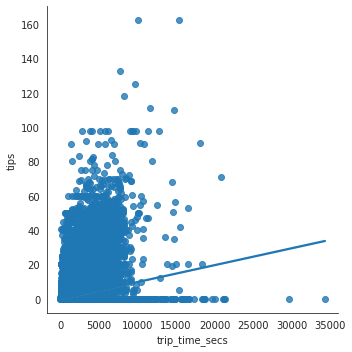

In [0]:
# VISUALIZATION 4 (RELATIONSHIP - TRIP TIME, TIPS)
# Relationship plot using Seaborn
import seaborn as sns
# Take the order total column and convert to a Pandas dataframe
trip_time_secs_tips_df = transformed_sdf.select('trip_time_secs', 'tips').sample(False, 0.25).toPandas() 

# Set the style for Seaborn plots
sns.set_style("white")

# Create the relationship plot
sns.lmplot(x='trip_time_secs', y='tips', data=trip_time_secs_tips_df)

Out[5]: <seaborn.axisgrid.FacetGrid at 0x7fb2bcbd5be0>

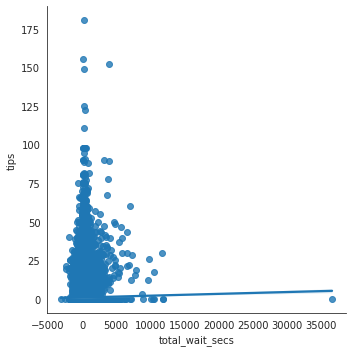

In [0]:
# VISUALIZATION 5 (RELATIONSHIP - TOTAL WAIT SECS, TIPS)
# Relationship plot using Seaborn
import seaborn as sns
# Take the 'total_wait_secs' and 'tips' columns and convert to a Pandas dataframe
total_wait_secs_tips_df = transformed_sdf.select('total_wait_secs', 'tips').sample(False, 0.25).toPandas() 

# Set the style for Seaborn plots
sns.set_style("white")

# Create the relationship plot
sns.lmplot(x='total_wait_secs', y='tips', data=total_wait_secs_tips_df)

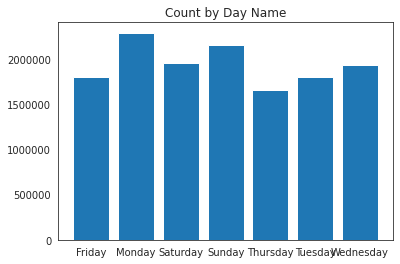

In [0]:
# VISUALIZATION 6 (BAR - DAY NAME)

# Show frequency of the 'day_name' column
day_name_df = transformed_sdf.groupby('day_name').count().sort('day_name').toPandas()
# Set up a figure
fig = plt.figure(facecolor='white')
plt.ticklabel_format(style='plain')
# Bar Plot of 'day_name' and count
plt.bar(day_name_df['day_name'],day_name_df['count'])
plt.title("Count by Day Name")
plt.savefig("frequency_day_name.png")

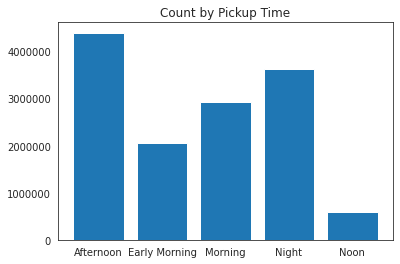

In [0]:
# VISUALIZATION 7 (BAR - PICKUP TIME OF DAY)

# Show frequency of the 'pickup_time_of_day' column
pickup_time_of_day_df = transformed_sdf.groupby('pickup_time_of_day').count().sort('pickup_time_of_day').toPandas()
# Set up a figure
fig = plt.figure(facecolor='white')
plt.ticklabel_format(style='plain')
# Bar Plot of 'pickup_time_of_day' and count
plt.bar(pickup_time_of_day_df['pickup_time_of_day'],pickup_time_of_day_df['count'])
plt.title("Count by Pickup Time")
plt.savefig("frequency_pickup_time_of_day.png")

In [0]:
# trip_time_secs (vector)
# FEATURE ENGINEERING

# Rename trip_time to trip_time_secs

trip_time_sec = clean_sdf.withColumnRenamed('trip_time', 'trip_time_secs')

#==============================================================================================================================================================#

# Subtract request_datetime from pickup_datetime to get total wait time from after request was submitted, in seconds

total_wait_secs_sdf = trip_time_sec.withColumn('total_wait_secs', col('pickup_datetime').cast('double') - col('request_datetime').cast('double'))

#==============================================================================================================================================================#

# Extract the hour from pickup_datetime to know what time of day the ride occurred

pickup_hour_sdf = total_wait_secs_sdf.withColumn('pickup_hour', hour(col('pickup_datetime')).cast('double'))

# Bucketize pickup_hour by 6 hour periods: <=6 = Early Morning, <12 = Morning, ==12 = Noon, <=18 = Afternoon, <=24 = Night

bucketized_pickup_hour_sdf = pickup_hour_sdf.withColumn('pickup_time_of_day', when(col('pickup_hour') <= 6, 'Early Morning').when(col('pickup_hour') < 12, "Morning").when(col('pickup_hour') == 12, 'Noon').when(col('pickup_hour') <= 18, "Afternoon").when(col('pickup_hour') <= 24, "Night"))

#==============================================================================================================================================================#

# Extract the day of the week from pickup_datetime to know what day the ride occurred

day_of_week_num_sdf = bucketized_pickup_hour_sdf.withColumn('day_of_week_num', dayofweek(col('pickup_datetime')).cast('double'))

# Create a column called day_name to specify the day name associated with day_of_week_num

bucketized_day_name_sdf = day_of_week_num_sdf.withColumn('day_name', when(col('day_of_week_num') == 1, 'Monday').when(col('day_of_week_num') == 2, 'Tuesday').when(col('day_of_week_num') == 3, 'Wednesday').when(col('day_of_week_num') == 4, 'Thursday').when(col('day_of_week_num') == 5, 'Friday').when(col('day_of_week_num') == 6, 'Saturday').when(col('day_of_week_num') == 7, 'Sunday'))

# Binarize day_of_week to 0 or 1, where 0.0 = Weekday, 1.0 = Weekend

binarizer_day = Binarizer(threshold=5.0, inputCol='day_of_week_num', outputCol='weekday_or_weekend')
weekday_or_weekend_sdf = binarizer_day.transform(bucketized_day_name_sdf)

#==============================================================================================================================================================#

# Create a column called total_fare that includes all of the ride costs

total_fare_sdf = weekday_or_weekend_sdf.withColumn('total_fare', col('base_passenger_fare') + col('tolls') + col('bcf') + col('sales_tax') + col('congestion_surcharge') + col('airport_fee'))

# Drop all rows where total_fare is equal to 0.0 to avoid a divide by zero error
# Create a column called tip_percent that is tips divided by total_fare to get the tip percent

non_zero_fare = total_fare_sdf.where(col('total_fare') > 0.0)
tip_percent_sdf = non_zero_fare.withColumn('tip_percent', col('tips') / col('total_fare'))

tip_percent_sdf.show()

+-------------------+-------------------+-------------------+-------------------+----------+--------------+-------------------+-----+----+---------+--------------------+-----------+-----+---------------+-----------+------------------+---------------+--------+------------------+------------------+-------------------+
|   request_datetime|  on_scene_datetime|    pickup_datetime|   dropoff_datetime|trip_miles|trip_time_secs|base_passenger_fare|tolls| bcf|sales_tax|congestion_surcharge|airport_fee| tips|total_wait_secs|pickup_hour|pickup_time_of_day|day_of_week_num|day_name|weekday_or_weekend|        total_fare|        tip_percent|
+-------------------+-------------------+-------------------+-------------------+----------+--------------+-------------------+-----+----+---------+--------------------+-----------+-----+---------------+-----------+------------------+---------------+--------+------------------+------------------+-------------------+
|2023-01-01 00:18:06|2023-01-01 00:19:24|2023-

In [0]:
# trip_time_secs (vector)
# ASSEMBLE PIPELINE

# Create a label. =1 if >= 0.15, =0 otherwise
binarizer_tip = Binarizer(threshold=0.15, inputCol='tip_percent', outputCol='label')
tip_label = binarizer_tip.transform(tip_percent_sdf)

# Create an indexer for the string based columns.
indexer = StringIndexer(inputCols=["pickup_time_of_day", "day_name"], outputCols=["pickup_time_of_day_index", "day_name_index"])

# Create an encoder for the three indexes and the age integer column.
encoder = OneHotEncoder(inputCols=["trip_time_secs", "pickup_time_of_day_index", "day_name_index"], outputCols=["trip_time_secs_vector", "pickup_time_of_day_vector", "day_name_vector"], dropLast=False)

# Create an assembler for the individual feature vectors and the float/double columns
assembler = VectorAssembler(inputCols=['trip_miles', 'trip_time_secs_vector', 'total_wait_secs', 'pickup_time_of_day_vector', 'day_name_vector', 'weekday_or_weekend', 'total_fare'], outputCol='features')

min_max_scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

# Create the pipeline
hvfhv_pipe = Pipeline(stages=[indexer, encoder, assembler, min_max_scaler])

# Call .fit to transform the data
transformed_sdf = hvfhv_pipe.fit(tip_label).transform(tip_label)

# Review the transformed features
transformed_sdf.select('trip_miles', 'trip_time_secs', 'total_wait_secs', 'pickup_time_of_day', 'day_name', 'weekday_or_weekend', 'total_fare', 'label', 'features', 'scaled_features').show(truncate=True)

+----------+--------------+---------------+------------------+--------+------------------+------------------+-----+--------------------+--------------------+
|trip_miles|trip_time_secs|total_wait_secs|pickup_time_of_day|day_name|weekday_or_weekend|        total_fare|label|            features|     scaled_features|
+----------+--------------+---------------+------------------+--------+------------------+------------------+-----+--------------------+--------------------+
|      0.94|          1709|           92.0|     Early Morning|  Monday|               0.0|             31.78|  1.0|(34912,[0,1710,34...|[0.00267676623857...|
|      2.78|          2069|          597.0|     Early Morning|  Monday|               0.0|             70.03|  0.0|(34912,[0,2070,34...|[0.00791639376939...|
|      8.81|          1047|          292.0|     Early Morning|  Monday|               0.0|             27.26|  0.0|(34912,[0,1048,34...|[0.02508756442748...|
|      0.67|           431|          341.0|     Earl

In [0]:
# EXTRA CODE
# Subtract request_datetime from pickup_datetime to get total wait time from after request was submitted, in minutes

# total_wait_mins_sdf = clean_sdf.withColumn('wait_hours', hour(col('pickup_datetime')) - hour(col('request_datetime'))).withColumn('wait_mins', minute(col('pickup_datetime')) - minute(col('request_datetime'))).withColumn('pos_wait_mins', abs(col('wait_mins'))).withColumn('wait_hours_to_mins', col('wait_hours') * 60).withColumn('total_wait_mins', col('pos_wait_mins').cast('double') + col('wait_hours_to_mins').cast('double'))

# Subtract pickup_datetime from dropoff_datetime to get total ride time in minutes

# total_ride_mins_sdf = total_wait_mins_sdf.withColumn('ride_hours', hour(col('dropoff_datetime')) - hour(col('pickup_datetime'))).withColumn('ride_mins', minute(col('dropoff_datetime')) - minute(col('pickup_datetime'))).withColumn('pos_ride_mins', abs(col('ride_mins'))).withColumn('hours_to_mins', col('ride_hours') * 60).withColumn('total_ride_mins', col('pos_ride_mins').cast('double') + col('hours_to_mins').cast('double'))

# Drop all unnecessary columns 

# new_cols_sdf = day_of_week_sdf.drop('ride_hours', 'ride_mins', 'pos_ride_mins', 'hours_to_mins', 'wait_hours', 'wait_mins', 'pos_wait_mins', 'wait_hours_to_mins')

# Subtract pickup_datetime from dropoff_datetime to get total ride time in seconds

# total_ride_secs_sdf = total_wait_secs_sdf.withColumn('total_ride_secs', col('dropoff_datetime').cast('long') - col('pickup_datetime').cast('long'))

# Bucketize pickup_hour by 6 hour intervals

# bucketizer_hour = Bucketizer(splits=[0.0, 6.0, 12.0, 18.0, 24.0], inputCol='pickup_hour', outputCol='pickup_time_of_day')
# bucketized_pickup_hour_sdf = bucketizer.transform(pickup_hour_sdf)

# bucketized_pickup_hour_sdf = pickup_hour_sdf.withColumn('pickup_time_of_day', when(col('pickup_hour') <= 6, 'Early Morning').when(col('pickup_hour') < 12, "Morning").when(col('pickup_hour') == 12, 'Noon').when(col('pickup_hour') <= 18, "Afternoon").when(col('pickup_hour') <= 24, "Night"))

# Bucketize tip_percent

# bucketizer_tip = Bucketizer(splits=[0.0, 0.05, 0.20, 1.0], inputCol='tip_percent', outputCol='tip_category')
# bucketized_tip_percent_sdf = bucketizer.transform(tip_percent_sdf)

# tip_category_sdf = tip_percent_sdf.withColumn('tip_category', when(col('tip_percent') == 0.0, 'No Tip').when(col('tip_percent') <= 0.05, 'Bad Tip').when(col('tip_percent') <= 0.20, 'Good Tip').when(col('tip_percent') <= 1.0, 'Excellent Tip'))

# OneHotEncode day_of_week

# encoder_day = OneHotEncoder(inputCol=['day_of_week'], outputCol=['day_vector'], dropLast=False)
# model = encoder_day.fit(tip_category_sdf)
# encoded_sdf = model.transform(tip_category_sdf)

In [0]:
# ORIGINAL COMBINED

### Add or extract new features/columns

# Convert trip_time from long to double

trip_time_sec = clean_sdf.withColumnRenamed('trip_time', 'trip_time_secs')
trip_time_sec_sdf = trip_time_sec.withColumn('trip_time_secs', col('trip_time_secs').cast('double'))

#==============================================================================================================================================================#

# Subtract request_datetime from pickup_datetime to get total wait time from after request was submitted, in seconds

total_wait_secs_sdf = trip_time_sec_sdf.withColumn('total_wait_secs', col('pickup_datetime').cast('double') - col('request_datetime').cast('double'))

#==============================================================================================================================================================#

# Extract the hour from pickup_datetime to know what time of day the ride occurred

pickup_hour_sdf = total_wait_secs_sdf.withColumn('pickup_hour', hour(col('pickup_datetime')).cast('double'))

# Bucketize pickup_hour by 6 hour periods: <=6 = Early Morning, <12 = Morning, ==12 = Noon, <=18 = Afternoon, <=24 = Night

bucketized_pickup_hour_sdf = pickup_hour_sdf.withColumn('pickup_time_of_day', when(col('pickup_hour') <= 6, 'Early Morning').when(col('pickup_hour') < 12, "Morning").when(col('pickup_hour') == 12, 'Noon').when(col('pickup_hour') <= 18, "Afternoon").when(col('pickup_hour') <= 24, "Night"))

# Index pickup_time_of_day

indexer_pickup_time_of_day = StringIndexer(inputCol="pickup_time_of_day", outputCol="pickup_time_of_day_index")
indexed_pickup_time_of_day_sdf = indexer_pickup_time_of_day.fit(bucketized_pickup_hour_sdf).transform(bucketized_pickup_hour_sdf)

# One Hot Encode pickup_time_of_day_index

encoder_pickup_time_of_day = OneHotEncoder(inputCol='pickup_time_of_day_index', outputCol='pickup_time_of_day_vector', dropLast=False)
model_pickup_time_of_day = encoder_pickup_time_of_day.fit(indexed_pickup_time_of_day_sdf)
encoded_pickup_time_of_day_sdf = model_pickup_time_of_day.transform(indexed_pickup_time_of_day_sdf)

#==============================================================================================================================================================#

# Extract the day of the week from pickup_datetime to know what day the ride occurred

day_of_week_num_sdf = encoded_pickup_time_of_day_sdf.withColumn('day_of_week_num', dayofweek(col('pickup_datetime')).cast('double'))

# Create a column called day_name to specify the day name associated with day_of_week_num

bucketized_day_name_sdf = day_of_week_num_sdf.withColumn('day_name', when(col('day_of_week_num') == 1, 'Monday').when(col('day_of_week_num') == 2, 'Tuesday').when(col('day_of_week_num') == 3, 'Wednesday').when(col('day_of_week_num') == 4, 'Thursday').when(col('day_of_week_num') == 5, 'Friday').when(col('day_of_week_num') == 6, 'Saturday').when(col('day_of_week_num') == 7, 'Sunday'))

# Index day_name

indexer_day = StringIndexer(inputCol="day_name", outputCol="day_name_index")
indexed_day_sdf = indexer_day.fit(bucketized_day_name_sdf).transform(bucketized_day_name_sdf)

# One Hot Encode day_name_index

encoder_day = OneHotEncoder(inputCol='day_name_index', outputCol='day_vector', dropLast=False)
model_day = encoder_day.fit(indexed_day_sdf)
encoded_day_sdf = model_day.transform(indexed_day_sdf)

# Binarize day_of_week to 0 or 1, where 0.0 = Weekday, 1.0 = Weekend

binarizer_day = Binarizer(threshold=5.0, inputCol='day_of_week_num', outputCol='weekday_or_weekend')
weekday_or_weekend_sdf = binarizer_day.transform(encoded_day_sdf)

#==============================================================================================================================================================#

# Create a column called total_fare that includes all of the ride costs

total_fare_sdf = weekday_or_weekend_sdf.withColumn('total_fare', col('base_passenger_fare') + col('tolls') + col('bcf') + col('sales_tax') + col('congestion_surcharge') + col('airport_fee'))

# Drop all rows where total_fare is equal to 0.0 to avoid a divide by zero error
# Create a column called tip_percent that is tips divided by total_fare to get the tip percent

non_zero_fare = total_fare_sdf.where(col('total_fare') > 0.0)
tip_percent_sdf = non_zero_fare.withColumn('tip_percent', col('tips') / col('total_fare'))

# Binarize tip_percent into 2 categories, < 0.15 = 0.0, > 0.15 = 1.0

binarizer_tip = Binarizer(threshold=0.15, inputCol='tip_percent', outputCol='tip_category')
tip_category_sdf = binarizer_tip.transform(tip_percent_sdf)

tip_category_sdf.show()

+-------------------+-------------------+-------------------+-------------------+----------+--------------+-------------------+-----+----+---------+--------------------+-----------+-----+---------------+-----------+------------------+------------------------+-------------------------+---------------+--------+--------------+-------------+------------------+------------------+-------------------+------------+
|   request_datetime|  on_scene_datetime|    pickup_datetime|   dropoff_datetime|trip_miles|trip_time_secs|base_passenger_fare|tolls| bcf|sales_tax|congestion_surcharge|airport_fee| tips|total_wait_secs|pickup_hour|pickup_time_of_day|pickup_time_of_day_index|pickup_time_of_day_vector|day_of_week_num|day_name|day_name_index|   day_vector|weekday_or_weekend|        total_fare|        tip_percent|tip_category|
+-------------------+-------------------+-------------------+-------------------+----------+--------------+-------------------+-----+----+---------+--------------------+---------

In [0]:
# Drop unnecessary columns

new_fe_sdf = tip_category_sdf.drop('request_datetime', 'on_scene_datetime', 'pickup_datetime', 'dropoff_datetime', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax', 'congestion_surcharge', 'airport_fee')

# Apply the VectorAssembler on my 7 chosen features 'trip_miles', 'trip_time_secs', 'total_wait_secs', 'pickup_time_of_day_vector', 'day_vector', 'weekday_or_weekend', 'total_fare'

vector_assembler = VectorAssembler(inputCols=['trip_miles', 'trip_time_secs', 'total_wait_secs', 'pickup_time_of_day_vector', 'day_vector', 'weekday_or_weekend', 'total_fare'], outputCol='features')
vector_assembled_sdf = vector_assembler.transform(new_fe_sdf)

# Scale the features column to min = 0.0 and max = 1.0

min_max_scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')
scaled_model_sdf = min_max_scaler.fit(vector_assembled_sdf)
scaled_sdf = scaled_model_sdf.transform(vector_assembled_sdf)
scaled_sdf.show(truncate=False)

# assembled_sdf.select(['trip_miles', 'trip_time_secs', 'total_wait_secs', 'pickup_time_of_day_vector', 'day_vector', 'weekday_or_weekend', 'total_fare', 'features']).show(truncate=False)

+----------+--------------+-----+---------------+-----------+------------------+------------------------+-------------------------+---------------+--------+--------------+-------------+------------------+------------------+-------------------+------------+------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------+
|trip_miles|trip_time_secs|tips |total_wait_secs|pickup_hour|pickup_time_of_day|pickup_time_of_day_index|pickup_time_of_day_vector|day_of_week_num|day_name|day_name_index|day_vector   |weekday_or_weekend|total_fare        |tip_percent        |tip_category|features                                                          |scaled_features                                                                                                  |
+----------+--------------+-----+---------------+-----------+------------------+------------------------+-------------------